In [86]:
import pandas as pd
import glob
import re
import os

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [87]:


# Path to the directory containing the CSV files
# Replace this with your directory path
path = './gplinear'  # Current directory, modify as needed

# Get all CSV files that match the pattern
csv_files = glob.glob(os.path.join(path, 'qhaplo_*qtl_*n_phenotype_correlations_untuned.csv'))

# Create an empty list to store individual dataframes
dfs = []

# Process each file
for file in csv_files:
    # Extract the filename from the path
    filename = os.path.basename(file)

    # Extract parameters using regex
    # Pattern looks for numbers after 'qtl_' and before 'n_'
    qtl_match = re.search(r'(\d+)qtl', filename)
    n_match = re.search(r'(\d+)n', filename)

    if qtl_match and n_match:
        qtl_value = int(qtl_match.group(1))
        n_value = int(n_match.group(1))

        # Read the CSV file
        df = pd.read_csv(file)

        # Add columns for the parameters
        df['qtl_param'] = qtl_value
        df['n_param'] = n_value

        # Add the dataframe to our list
        dfs.append(df)
    else:
        print(f"Couldn't extract parameters from {filename}")

# Combine all dataframes into one
if dfs:
    linear_df = pd.concat(dfs, ignore_index=True)

    # Display the first few rows of the combined dataframe
    print(linear_df.head())

    # Save the combined dataframe to a new CSV if needed
    # combined_df.to_csv('combined_summary.csv', index=False)
else:
    print("No matching files found or parameters couldn't be extracted")

No matching files found or parameters couldn't be extracted


In [88]:


# Path to the directory containing the CSV files
# Replace this with your directory path
path = './gpnet'  # Current directory, modify as needed

# Get all CSV files that match the pattern
csv_files = glob.glob(os.path.join(path, 'qhaplo_*qtl_*n_phenotype_correlations_untuned.csv'))

# Create an empty list to store individual dataframes
dfs = []

# Process each file
for file in csv_files:
    # Extract the filename from the path
    filename = os.path.basename(file)

    # Extract parameters using regex
    # Pattern looks for numbers after 'qtl_' and before 'n_'
    qtl_match = re.search(r'(\d+)qtl', filename)
    n_match = re.search(r'(\d+)n', filename)

    if qtl_match and n_match:
        qtl_value = int(qtl_match.group(1))
        n_value = int(n_match.group(1))

        # Read the CSV file
        df = pd.read_csv(file)

        # Add columns for the parameters
        df['qtl_param'] = qtl_value
        df['n_param'] = n_value

        # Add the dataframe to our list
        dfs.append(df)
    else:
        print(f"Couldn't extract parameters from {filename}")

# Combine all dataframes into one
if dfs:
    neural_df = pd.concat(dfs, ignore_index=True)

    # Display the first few rows of the combined dataframe
    print(neural_df.head())

    # Save the combined dataframe to a new CSV if needed
    # combined_df.to_csv('combined_summary.csv', index=False)
else:
    print("No matching files found or parameters couldn't be extracted")

No matching files found or parameters couldn't be extracted


In [89]:
linear_df.rename(columns={'pearson_correlation':'pearson_correlation'}, inplace=True)
neural_df.rename(columns={'pearson_correlation':'pearson_correlation'}, inplace=True)


In [90]:
def get_parameter_combinations(df1, df2):
    # Get all unique combinations from both dataframes
    params1 = df1[['qtl_param', 'n_param', 'trait_number']].drop_duplicates()
    params2 = df2[['qtl_param', 'n_param', 'trait_number']].drop_duplicates()

    # Find common combinations using merge
    common_params = pd.merge(params1, params2, on=['qtl_param', 'n_param', 'trait_number'])

    return common_params

# Get common parameter combinations
common_params = get_parameter_combinations(linear_df, neural_df)


In [91]:
comparison_data = []

for _, row in common_params.iterrows():
    qtl = row['qtl_param']
    n = row['n_param']
    trait = row['trait_number']

    linear_row = linear_df[(linear_df['qtl_param'] == qtl) &
                           (linear_df['n_param'] == n) &
                           (linear_df['trait_number'] == trait)]

    neural_row = neural_df[(neural_df['qtl_param'] == qtl) &
                           (neural_df['n_param'] == n) &
                           (neural_df['trait_number'] == trait)]

    if not linear_row.empty and not neural_row.empty:
        comparison_data.append({
            'qtl_param': qtl,
            'n_param': n,
            'trait_number': trait,
            'linear_correlation': linear_row['pearson_correlation'].values[0],
            'neural_correlation': neural_row['pearson_correlation'].values[0],
            'difference': (neural_row['pearson_correlation'].values[0] - linear_row['pearson_correlation'].values[0])/linear_row['pearson_correlation'].values[0]
        })

comparison_df = pd.DataFrame(comparison_data)


In [92]:
def plot_difference_heatmap(comparison_df):
    """
    Creates separate side-by-side heatmaps for each trait with QTL on x-axis and sample size on y-axis.
    """

    # Get unique traits, QTL parameters, and sample sizes
    unique_traits = sorted(comparison_df['trait_number'].unique())
    unique_qtls = sorted(comparison_df['qtl_param'].unique())
    unique_n = sorted(comparison_df['n_param'].unique())

    num_traits = len(unique_traits)

    # Create a figure with subplots (one for each trait)
    fig, axes = plt.subplots(1, num_traits, figsize=(10*num_traits, 6), sharey=True)

    # If there's only one trait, axes won't be an array
    if num_traits == 1:
        axes = [axes]

    # Define a custom diverging colormap (blue for positive, red for negative)
    cmap = sns.diverging_palette(240, 10, as_cmap=True)

    # Find global min and max for consistent color scale
    vmin = comparison_df['difference'].min()
    vmax = comparison_df['difference'].max()

    # Ensure the colormap is centered at zero
    abs_max = max(abs(vmin), abs(vmax))
    vmin, vmax = -abs_max, abs_max

    for i, trait in enumerate(unique_traits):
        # Filter data for this trait
        trait_data = comparison_df[comparison_df['trait_number'] == trait]

        # Create a pivot table with QTL on x-axis and sample size on y-axis
        pivot_data = trait_data.pivot_table(
            index='n_param',
            columns='qtl_param',
            values='difference'
        )

        # Plot the heatmap
        sns.heatmap(
            pivot_data,
            ax=axes[i],
            cmap=cmap,
            vmin=-1,
            vmax=1,
            center=0,
            annot=True,           # Show the values in cells
            fmt=".3f",            # Format of the annotations
            linewidths=0.5,       # Width of the lines between cells
            cbar=True if i == num_traits-1 else False  # Only show colorbar for the last plot
        )

        # Set title and labels
        axes[i].set_title(f'Trait {trait}')
        axes[i].set_xlabel('QTL Number')

        if i == 0:
            axes[i].set_ylabel('Sample Size')

    plt.suptitle('Neural Network vs Linear Model Performance Difference by Trait', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make room for the suptitle

    return fig

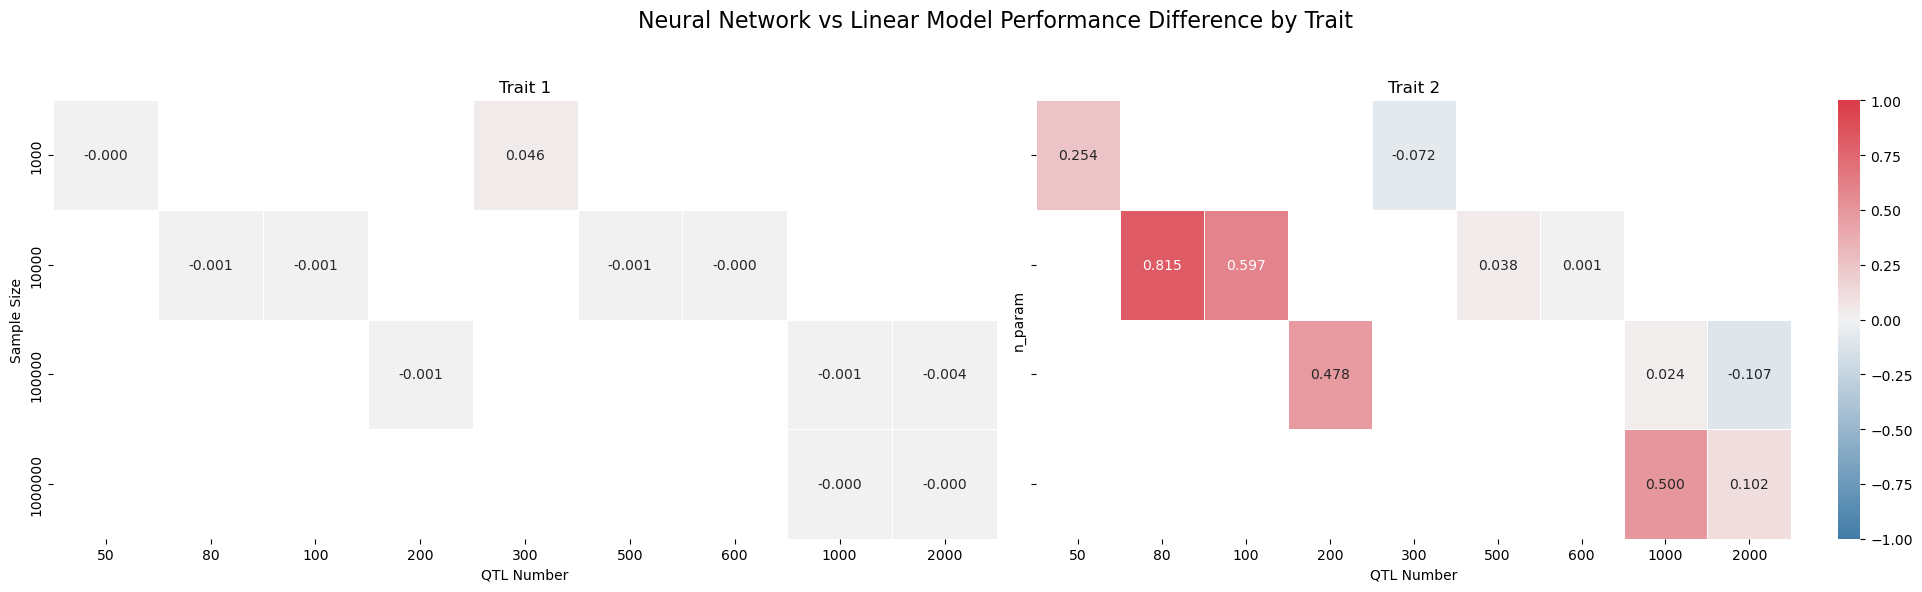

In [93]:
pl2 = plot_difference_heatmap(comparison_df)
pl2.show()

In [94]:
comparison_df.head()

,qtl_param,n_param,trait_number,linear_correlation,neural_correlation,difference
0,80,10000,1,0.999437,0.998468,-0.000969
1,80,10000,2,0.535406,0.972020,0.815481
2,600,10000,1,0.998960,0.998617,-0.000343
3,600,10000,2,0.527973,0.528301,0.000621
4,50,1000,1,0.997906,0.997546,-0.000361


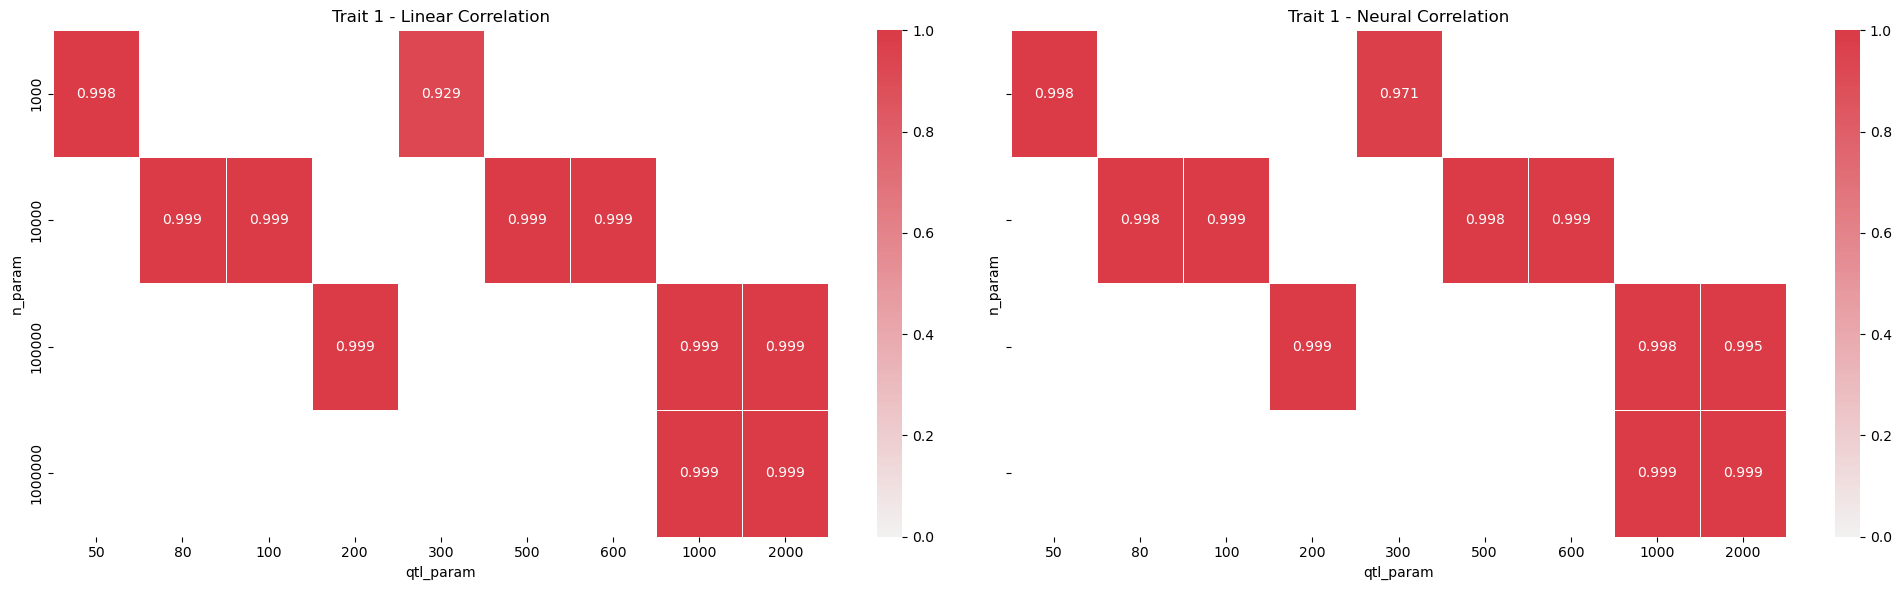

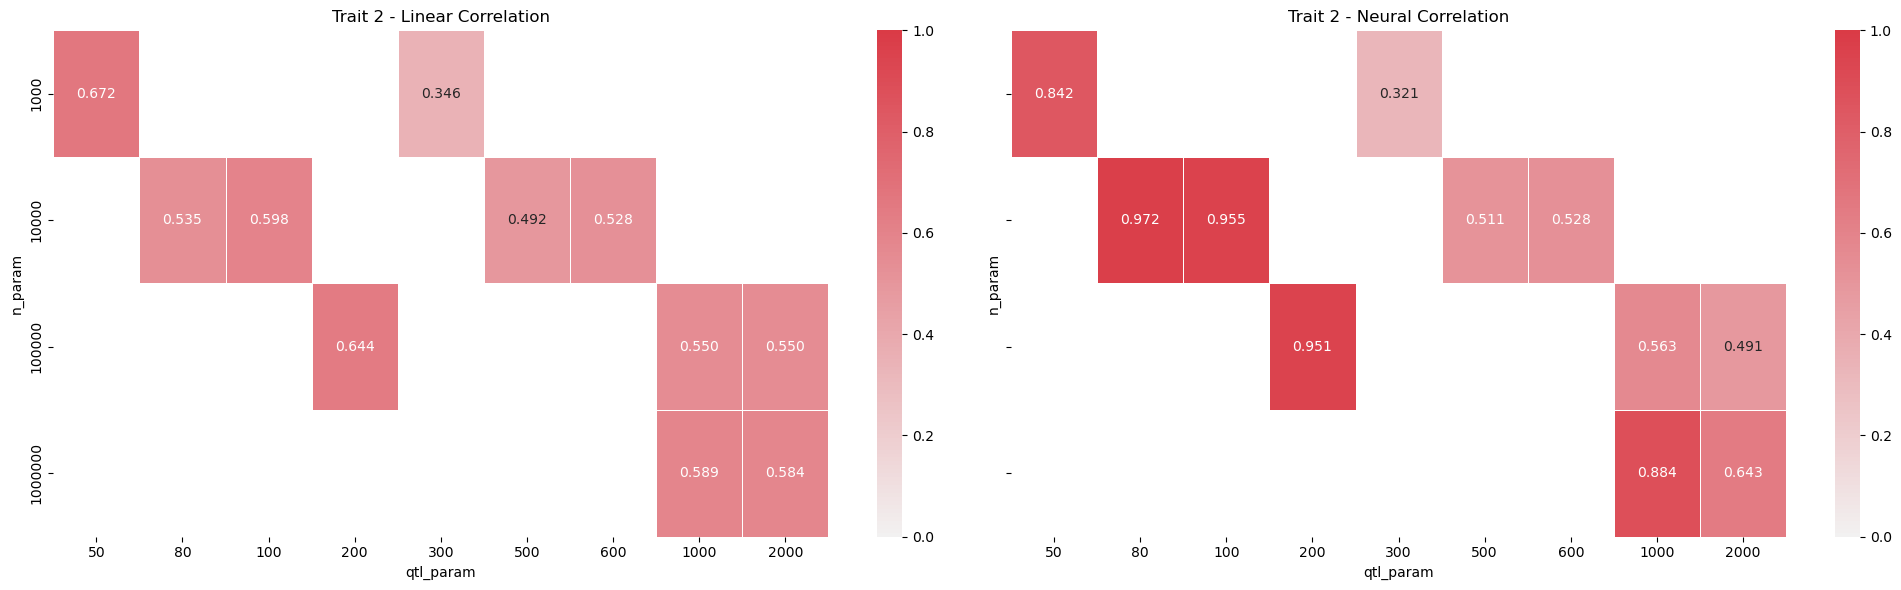

In [95]:
unique_traits = sorted(comparison_df['trait_number'].unique())

for i, trait in enumerate(unique_traits):
    # Filter data for this trait
    trait_data = comparison_df[comparison_df['trait_number'] == trait]

    # Create a figure with two subplots side by side
    fig, axes = plt.subplots(1, 2, figsize=(20, 6), sharey=True)
    cmap = sns.diverging_palette(240, 10, as_cmap=True)

    # Create pivot tables for both correlation types
    linear_pivot = trait_data.pivot_table(
        index='n_param',
        columns='qtl_param',
        values='linear_correlation'
    )

    neural_pivot = trait_data.pivot_table(
        index='n_param',
        columns='qtl_param',
        values='neural_correlation'
    )

    # Plot linear correlation heatmap
    sns.heatmap(
        linear_pivot,
        ax=axes[0],
        cmap=cmap,
        vmin=0,
        vmax=1,
        center=0,
        annot=True,
        fmt=".3f",
        linewidths=0.5,
        cbar=True
    )
    axes[0].set_title(f'Trait {trait} - Linear Correlation')

    # Plot neural correlation heatmap
    sns.heatmap(
        neural_pivot,
        ax=axes[1],
        cmap=cmap,
        vmin=0,
        vmax=1,
        center=0,
        annot=True,
        fmt=".3f",
        linewidths=0.5,
        cbar=True
    )
    axes[1].set_title(f'Trait {trait} - Neural Correlation')

    plt.tight_layout()
    plt.show()


In [96]:
def plot_difference_scatter(comparison_df):
    """
    Creates a scatter plot with fitted splines showing the difference between neural and linear models,
    with QTL number on x-axis (log scaled) and difference on y-axis.
    Points and splines are colored by sample size.
    """
    import numpy as np
    from scipy.interpolate import UnivariateSpline

    # Get unique traits and sample sizes
    unique_traits = sorted(comparison_df['trait_number'].unique())
    unique_n = sorted(comparison_df['n_param'].unique())

    num_traits = len(unique_traits)

    # Create a figure with subplots
    fig, axes = plt.subplots(1, num_traits, figsize=(5*num_traits, 6), sharey=True)

    # If there's only one trait, axes won't be an array
    if num_traits == 1:
        axes = [axes]

    # Create a colormap for sample sizes
    cmap = plt.cm.viridis
    colors = cmap(np.linspace(0, 1, len(unique_n)))

    for i, trait in enumerate(unique_traits):
        # Filter data for this trait
        trait_data = comparison_df[comparison_df['trait_number'] == trait]

        # For each sample size, plot points and fit a smoother curve
        for j, n in enumerate(unique_n):
            # Filter data for this sample size
            n_data = trait_data[trait_data['n_param'] == n]

            # Sort by QTL parameter for proper fitting
            n_data = n_data.sort_values('qtl_param')

            # Extract x and y data
            x_data = n_data['qtl_param'].values
            y_data = n_data['difference'].values

            # Plot the scatter points
            axes[i].scatter(x_data, y_data, color=colors[j], s=50, alpha=0.7)

            # Only proceed if we have enough data points
            if len(x_data) >= 4:
                # Use log of x for fitting to handle the log scale properly
                log_x = np.log10(x_data)

                # Fit a smoother spline with regularization
                # Adjust smoothing factor s to control how closely the curve follows points
                s = len(x_data) * 0.1  # Adjust this value as needed
                try:
                    spline = UnivariateSpline(log_x, y_data, s=s)

                    # Create smooth points for plotting
                    log_x_smooth = np.linspace(min(log_x), max(log_x), 100)
                    y_smooth = spline(log_x_smooth)

                    # Convert back to original scale for plotting
                    x_smooth = 10**log_x_smooth

                    # Plot the smoothed line
                    axes[i].plot(x_smooth, y_smooth, '-', color=colors[j],
                                linewidth=2, label=f'n = {n}' if i == 0 else "")
                except Exception:
                    # If spline fitting fails, use a simpler approach
                    # Just connect the points with straight lines
                    axes[i].plot(x_data, y_data, '-', color=colors[j], alpha=0.5,
                                linewidth=1.5, label=f'n = {n}' if i == 0 else "")

        # Set x-axis to log scale
        axes[i].set_xscale('log')

        # Add a horizontal line at y=0
        axes[i].axhline(y=0, color='gray', linestyle='--', alpha=0.7)

        # Set title and labels
        axes[i].set_title(f'Trait {trait}')
        axes[i].set_xlabel('QTL Number (log scale)')

        if i == 0:
            axes[i].set_ylabel('Difference (Neural - Linear)')

        # Set y-axis limits consistently
        y_max = abs(comparison_df['difference']).max() * 1.1  # Add 10% padding
        axes[i].set_ylim(-y_max, y_max)

    # Add legend
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.005),
              ncol=len(unique_n), title="Sample Size")

    plt.suptitle('Neural Network vs Linear Model Performance Difference by Trait', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.90])  # Adjust layout for suptitle and legend


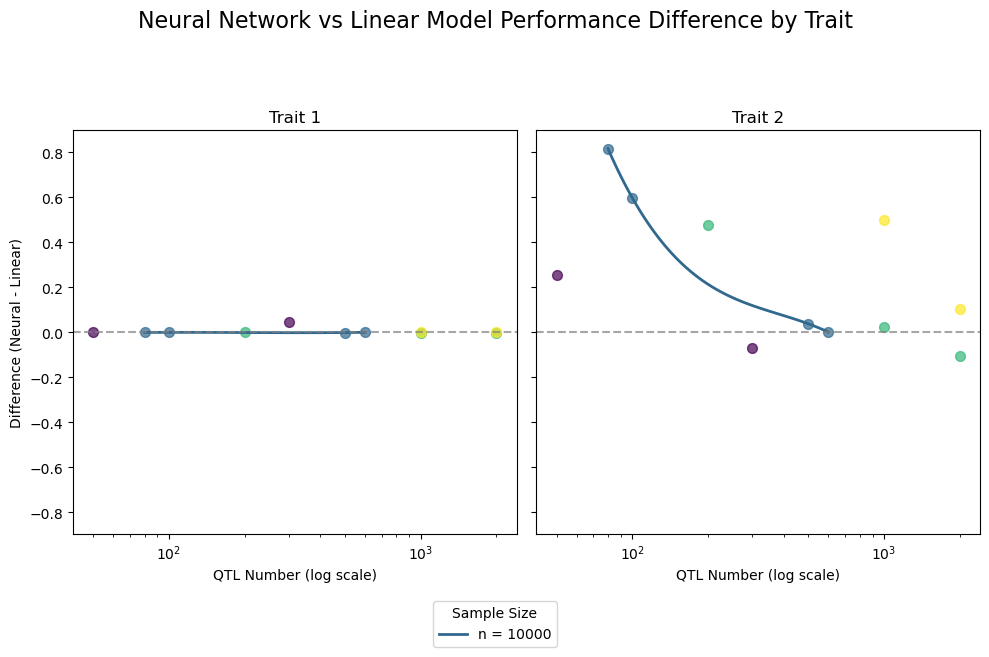

In [97]:
plot_difference_scatter(comparison_df)

In [98]:
def plot_correlation_scatter(comparison_df, correlation_type='neural_correlation'):
    """
    Creates a scatter plot with fitted splines showing the specified correlation type,
    with QTL number on x-axis (log scaled) and correlation on y-axis.
    Points and splines are colored by sample size.

    Parameters:
    -----------
    comparison_df : pandas DataFrame
        The data frame containing the correlation data
    correlation_type : str, optional
        The type of correlation to plot. Default is 'neural_correlation'
        Options: 'neural_correlation', 'linear_correlation', 'difference'
    """
    import numpy as np
    from scipy.interpolate import UnivariateSpline

    # Validate correlation type
    valid_types = ['neural_correlation', 'linear_correlation', 'difference']
    if correlation_type not in valid_types:
        raise ValueError(f"correlation_type must be one of {valid_types}")

    # Set the appropriate title and y-line based on correlation type
    if correlation_type == 'neural_correlation':
        plot_title = 'Neural Network Performance (r2) by Trait'
        y_line = 0.6  # Example threshold line
        y_label = 'Neural Network validation r2'
    elif correlation_type == 'linear_correlation':
        plot_title = 'Linear Model Performance (r2) by Trait'
        y_line = 0.6  # Example threshold line
        y_label = 'Linear Model validation r2'
    else:  # 'difference'
        plot_title = 'Neural Network vs Linear Model Performance Difference by Trait'
        y_line = 0  # Zero line for difference
        y_label = 'Difference (Neural - Linear)'

    # Get unique traits and sample sizes
    unique_traits = sorted(comparison_df['trait_number'].unique())
    unique_n = sorted(comparison_df['n_param'].unique())

    num_traits = len(unique_traits)

    # Create a figure with subplots
    fig, axes = plt.subplots(1, num_traits, figsize=(5*num_traits, 6), sharey=True)

    # If there's only one trait, axes won't be an array
    if num_traits == 1:
        axes = [axes]

    # Create a colormap for sample sizes
    cmap = plt.cm.viridis
    colors = cmap(np.linspace(0, 1, len(unique_n)))

    for i, trait in enumerate(unique_traits):
        # Filter data for this trait
        trait_data = comparison_df[comparison_df['trait_number'] == trait]

        # For each sample size, plot points and fit a smoother curve
        for j, n in enumerate(unique_n):
            # Filter data for this sample size
            n_data = trait_data[trait_data['n_param'] == n]

            # Sort by QTL parameter for proper fitting
            n_data = n_data.sort_values('qtl_param')

            # Extract x and y data
            x_data = n_data['qtl_param'].values
            y_data = n_data[correlation_type].values

            # Plot the scatter points
            axes[i].scatter(x_data, y_data, color=colors[j], s=50, alpha=0.7)

            # Only proceed if we have enough data points
            if len(x_data) >= 4:
                # Use log of x for fitting to handle the log scale properly
                log_x = np.log10(x_data)

                # Fit a smoother spline with regularization
                # Adjust smoothing factor s to control how closely the curve follows points
                s = len(x_data) * 0.1  # Adjust this value as needed
                try:
                    spline = UnivariateSpline(log_x, y_data, s=s)

                    # Create smooth points for plotting
                    log_x_smooth = np.linspace(min(log_x), max(log_x), 100)
                    y_smooth = spline(log_x_smooth)

                    # Convert back to original scale for plotting
                    x_smooth = 10**log_x_smooth

                    # Plot the smoothed line
                    axes[i].plot(x_smooth, y_smooth, '-', color=colors[j],
                                linewidth=2, label=f'n = {n}' if i == 0 else "")
                except Exception:
                    # If spline fitting fails, use a simpler approach
                    # Just connect the points with straight lines
                    axes[i].plot(x_data, y_data, '-', color=colors[j], alpha=0.5,
                                linewidth=1.5, label=f'n = {n}' if i == 0 else "")

        # Set x-axis to log scale
        axes[i].set_xscale('log')

        # Add a reference line
        axes[i].axhline(y=y_line, color='gray', linestyle='--', alpha=0.7)

        # Set title and labels
        axes[i].set_title(f'Trait {trait}')
        axes[i].set_xlabel('QTL Number (log scale)')

        if i == 0:
            axes[i].set_ylabel(y_label)

        # Set y-axis limits based on correlation type
        if correlation_type == 'difference':
            y_max = abs(comparison_df[correlation_type]).max() * 1.1
            axes[i].set_ylim(-y_max, y_max)
        else:
            axes[i].set_ylim(0, 1.1)

    # Add legend with better positioning to avoid overlap
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.05),
              ncol=min(len(unique_n), 4), title="Sample Size")

    plt.suptitle(plot_title, fontsize=16)
    plt.tight_layout(rect=[0, 0.1, 1, 0.93])  # Adjusted to leave room for legend at bottom


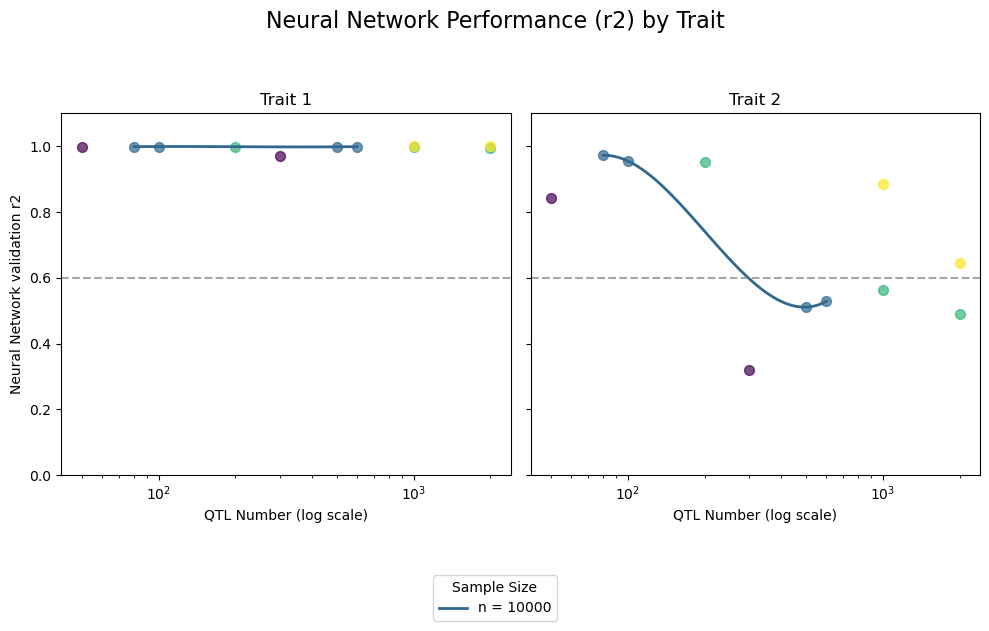

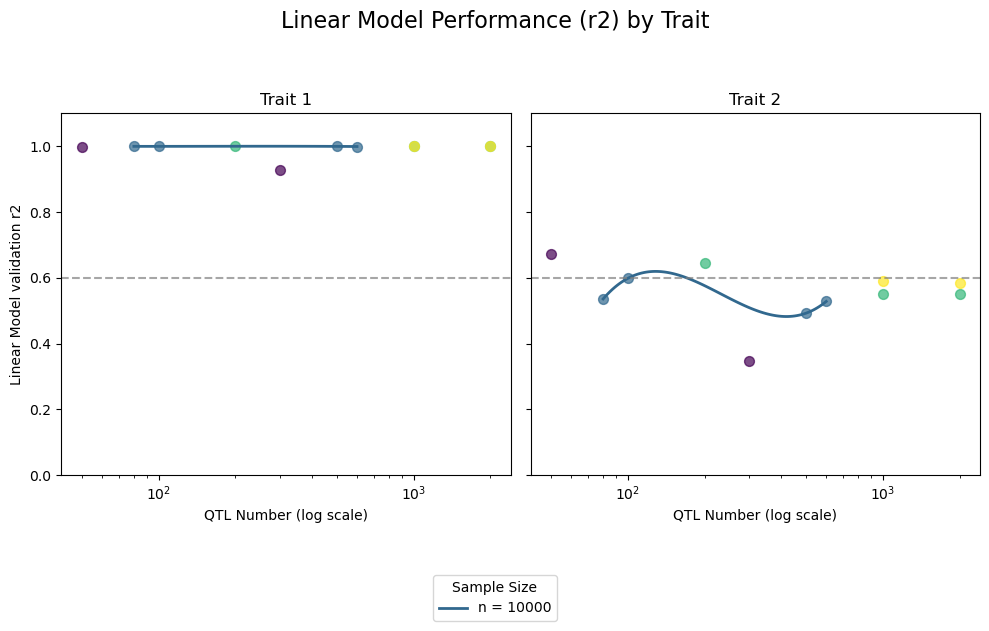

In [99]:
plot_correlation_scatter(comparison_df)
plot_correlation_scatter(comparison_df, correlation_type='linear_correlation')


   qtl_param  n_param  trait_number  linear_correlation  neural_correlation  \
0         80    10000             1            0.999437            0.998468   
1         80    10000             2            0.535406            0.972020   
2        600    10000             1            0.998960            0.998617   
3        600    10000             2            0.527973            0.528301   
4         50     1000             1            0.997906            0.997546   

   difference  scaled_qtl_n     log_N  
0   -0.000969         0.316  9.210340  
1    0.815481         0.316  9.210340  
2   -0.000343        17.970  9.210340  
3    0.000621        17.970  9.210340  
4   -0.000361         1.225  6.907755  


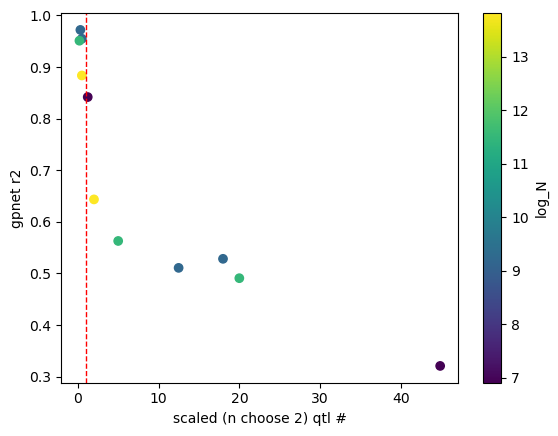

In [100]:
from math import comb

combination_values = []
for value in comparison_df['qtl_param']:
    combination_values.append(comb(value, 2))

comparison_df['scaled_qtl_n'] = combination_values/comparison_df['n_param']
#comparison_df['scaled_qtl_n'] = (comparison_df['qtl_param']^2)/comparison_df['n_param']

comparison_df['log_N'] = np.log(comparison_df['n_param'])

print(comparison_df.head())


trait2 = comparison_df[comparison_df['trait_number']==2]
plt.scatter(trait2['scaled_qtl_n'], trait2['neural_correlation'], c=trait2['log_N'], cmap='viridis')
plt.colorbar( label='log_N')
plt.grid(False)
plt.xlabel('scaled (n choose 2) qtl #')
plt.ylabel('gpnet r2')
plt.axvline(x=1, color='r', linestyle='--', linewidth=1)


Text(0, 0.5, 'gpnet r2')

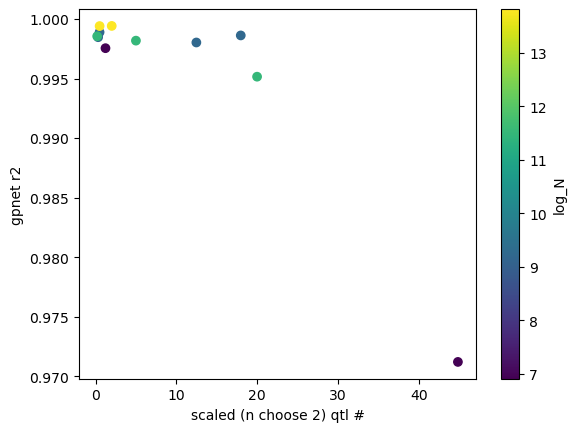

In [101]:
trait1 = comparison_df[comparison_df['trait_number']==1]
plt.scatter(trait1['scaled_qtl_n'], trait1['neural_correlation'], c=trait1['log_N'], cmap='viridis')
plt.colorbar( label='log_N')
plt.grid(False)
plt.xlabel('scaled (n choose 2) qtl #')
plt.ylabel('gpnet r2')

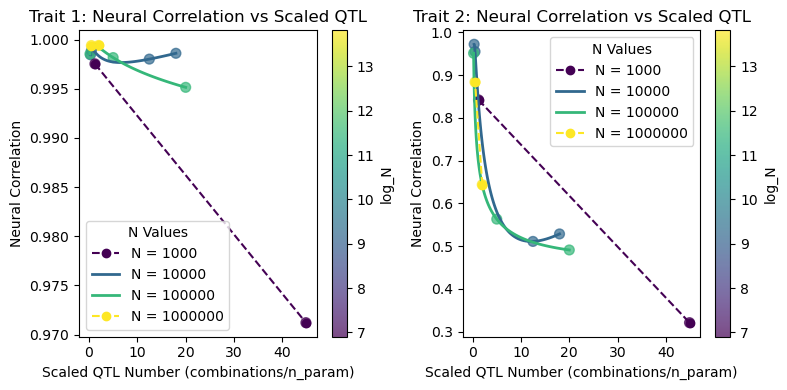

In [102]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline
from math import comb
import pandas as pd
from matplotlib.cm import viridis

# Your existing data preparation code
combination_values = []
for value in comparison_df['qtl_param']:
    combination_values.append(comb(value, 2))

comparison_df['scaled_qtl_n'] = combination_values/comparison_df['n_param']
comparison_df['log_N'] = np.log(comparison_df['n_param'])

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

# Function to add scatter and spline to an axis for a specific trait
def plot_trait_with_n_splines(ax, trait_num, title):
    # Filter data for this trait
    trait_df = comparison_df[comparison_df['trait_number'] == trait_num]

    # Create scatter plot with continuous log_N colors
    scatter = ax.scatter(
        trait_df['scaled_qtl_n'],
        trait_df['neural_correlation'],
        c=trait_df['log_N'],
        cmap='viridis',
        alpha=0.7,
        s=50
    )

    # Add a colorbar for log_N
    cbar = fig.colorbar(scatter, ax=ax, label='log_N')

    # Get unique N values and sort them
    unique_n_values = sorted(trait_df['n_param'].unique())

    # Get log_N range for color mapping
    log_n_min = trait_df['log_N'].min()
    log_n_max = trait_df['log_N'].max()

    # Add spline for each unique N value
    for n_value in unique_n_values:
        # Filter data for this N value
        n_df = trait_df[trait_df['n_param'] == n_value]

        # Only create spline if we have enough points (at least 3)
        if len(n_df) >= 3:
            # Get the log_N value for this N to match color
            log_n = np.log(n_value)
            normalized_value = (log_n - log_n_min) / (log_n_max - log_n_min)
            n_color = viridis(normalized_value)

            # Sort for proper spline interpolation
            n_df = n_df.sort_values('scaled_qtl_n')

            # Get x and y values
            x = n_df['scaled_qtl_n'].values
            y = n_df['neural_correlation'].values

            # Apply log transformation for the spline calculation
            x_log = np.log(x + 1e-10)  # Add small value to avoid log(0)

            # Generate smoother points for the spline curve (in log space)
            x_smooth_log = np.linspace(x_log.min(), x_log.max(), 100)

            # Use k=3 for cubic spline, or k=1 for linear if fewer points
            k = min(3, len(x) - 1)

            try:
                # Create and evaluate the spline
                spl = make_interp_spline(x_log, y, k=k)
                y_smooth = spl(x_smooth_log)

                # Convert back from log space for plotting
                x_smooth = np.exp(x_smooth_log)

                # Plot the spline with appropriate color and label
                ax.plot(x_smooth, y_smooth, color=n_color, linewidth=2, label=f'N = {n_value}')
            except:
                # If spline creation fails, use a simpler approach
                ax.plot(x, y, color=n_color, linestyle='--', marker='o',
                       linewidth=1.5, label=f'N = {n_value}')
        elif len(n_df) >= 2:
            # If not enough points for a spline, just connect the dots
            log_n = np.log(n_value)
            normalized_value = (log_n - log_n_min) / (log_n_max - log_n_min)
            n_color = viridis(normalized_value)

            ax.plot(n_df['scaled_qtl_n'], n_df['neural_correlation'],
                   color=n_color, linestyle='--', marker='o',
                   linewidth=1.5, label=f'N = {n_value}')

    # Add labels and title
    ax.set_xlabel('Scaled QTL Number (combinations/n_param)')
    ax.set_ylabel('Neural Correlation')
    ax.set_title(title)
    ax.grid(False)

    # Add legend, but only show a reasonable number of entries
    # If there are too many N values, use a subset for the legend
    if len(unique_n_values) > 10:
        # Choose a subset of N values to show in the legend
        legend_indices = np.linspace(0, len(unique_n_values)-1, 10, dtype=int)
        handles, labels = ax.get_legend_handles_labels()
        ax.legend([handles[i] for i in legend_indices],
                  [labels[i] for i in legend_indices],
                  title="N Values")
    else:
        ax.legend(title="N Values")

    return ax

# Plot trait 1 on the first subplot
plot_trait_with_n_splines(ax1, 1, 'Trait 1: Neural Correlation vs Scaled QTL')

# Plot trait 2 on the second subplot
plot_trait_with_n_splines(ax2, 2, 'Trait 2: Neural Correlation vs Scaled QTL')

# Adjust layout
plt.tight_layout()
plt.show()